In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import metrics

# from mlxtend.plotting import plot_decision_regions
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from ast import literal_eval

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, model, roc_results
from lob_data_utils.svm_calculation import lob_svm
import os


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
data_length = 15000
rs_params = [(0.1, 1.0), (1.0, 0.1), (1.0, 1.0), (0.1, 0.1)]
stocks = list(roc_results.result_cv_15000.keys())
data_dir = 'res_pca_gdf3_15000'

In [3]:
def get_mean_scores(scores: dict) -> dict:
    mean_scores = {}
    for k, v in scores.items():
        mean_scores[k] = np.mean(v)
    return mean_scores

def get_score_for_clf(clf, df_test):
    x_test = df_test[['queue_imbalance']]
    y_test = df_test['mid_price_indicator'].values
    return model.test_model(clf, x_test, y_test)

def get_logistic_regression(stock, data_length):
    df, df_test = lob.load_prepared_data(
        stock, data_dir='../gaussian_filter/data', cv=False, length=data_length)
    clf = LogisticRegression()
    train_x = df[['queue_imbalance']]

    scores = model.validate_model(clf, train_x, df['mid_price_indicator'])
    res = {
        **get_mean_scores(scores),
        'stock': stock,
        'kernel': 'logistic',
    }
    test_scores = get_score_for_clf(clf, df_test)
    return {**res, **test_scores}

In [4]:
df_res = pd.DataFrame()
for stock in stocks:
    for r, s in rs_params:
    #pd.read_csv('svm_features_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s))
        filename = data_dir + '/svm_pca_gdf_sigmoid_{}_len{}_r{}_s{}.csv'.format(stock, data_length, r, s)
        if os.path.exists(filename):
            df_temp = pd.read_csv(filename)
            df_temp['r'] = [r] * len(df_temp)
            df_temp['s'] = [s] * len(df_temp)
            df_res = df_res.append(df_temp)
#df_res.drop(columns=['Unnamed: 0'], inplace=True)
columns = ['C', 'coef0', 'gamma', 'f1', 'features', 'kappa',
           'matthews', 'roc_auc', 'stock',
       'test_f1', 'test_kappa', 'test_matthews', 'test_roc_auc', 'r', 's']
df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)

,C,coef0,gamma,f1,features,kappa,matthews,roc_auc,stock,test_f1,test_kappa,test_matthews,test_roc_auc,r,s
19,100.0,1.00,0.01,0.569032,pca_gdf_que3,0.125439,0.127451,0.562966,9269,0.575282,0.095643,0.096114,0.547757,0.1,1.0
19,100.0,1.00,0.01,0.485768,pca_gdf_que3,0.120629,0.121660,0.560428,9063,0.488224,0.088175,0.090541,0.544144,0.1,1.0
19,100.0,1.00,0.01,0.536815,pca_gdf_que3,0.116525,0.118144,0.558525,9067,0.502972,0.112206,0.115830,0.556416,1.0,0.1
9,1.0,0.01,0.01,0.560238,pca_gdf_que3,0.115730,0.117473,0.558076,10166,0.558518,0.094083,0.094149,0.547029,1.0,1.0
19,100.0,1.00,0.01,0.557248,pca_gdf_que3,0.110841,0.111135,0.555421,12059,0.552118,0.111756,0.111785,0.555903,0.1,1.0
18,100.0,0.01,0.01,0.560066,pca_gdf_que3,0.110094,0.110732,0.555145,9265,0.556446,0.114375,0.114377,0.557188,0.1,0.1
18,100.0,0.01,0.01,0.551510,pca_gdf_que3,0.100161,0.101184,0.550136,9069,0.556987,0.105625,0.105625,0.552812,1.0,1.0
19,100.0,1.00,0.01,0.553697,pca_gdf_que3,0.099838,0.100033,0.549917,9058,0.540594,0.072219,0.072317,0.536139,0.1,1.0
18,100.0,0.01,0.01,0.538234,pca_gdf_que3,0.097689,0.099004,0.549085,9061,0.522541,0.067405,0.067440,0.533694,1.0,0.1
19,100.0,1.00,0.01,0.523379,pca_gdf_que3,0.088409,0.089446,0.544344,9064,0.498538,0.088140,0.090150,0.544234,0.1,1.0


In [5]:
log_res = []
for stock in stocks:
    log_res.append(get_logistic_regression(stock, data_length))
df_log_res = pd.DataFrame(log_res)
df_log_res['stock'] = df_log_res['stock'].values.astype(np.int)
df_log_res.index = df_log_res['stock'].values.astype(np.int)

In [6]:
df_gdf_best = df_res[columns].sort_values(by='matthews', ascending=False).groupby('stock').head(1)
df_gdf_best['stock'] = df_gdf_best['stock'].values.astype(np.int)
df_gdf_best.index = df_gdf_best['stock'].values.astype(np.int)

In [7]:
df_all = pd.merge(df_gdf_best, df_log_res, on='stock', suffixes=['_svm', '_log'])

In [20]:
all_columns = [ 'features', 'matthews_svm', 'matthews_log',  'test_matthews_svm',  'test_matthews_log',
       'roc_auc_svm', 'roc_auc_log', 'test_roc_auc_svm',  'test_roc_auc_log', 'stock', 
               'f1_svm', 'f1_log', 'test_f1_svm', 'test_f1_log', 'r', 's']
df_all[all_columns]

,features,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock,f1_svm,f1_log,test_f1_svm,test_f1_log,r,s
0,pca_gdf_que3,0.127451,0.126346,0.096114,0.089181,0.562966,0.562127,0.547757,0.544212,9269,0.569032,0.545576,0.575282,0.514873,0.1,1.0
1,pca_gdf_que3,0.121660,0.126827,0.090541,0.118561,0.560428,0.562089,0.544144,0.559265,9063,0.485768,0.536674,0.488224,0.565703,0.1,1.0
2,pca_gdf_que3,0.118144,0.107716,0.115830,0.099328,0.558525,0.553333,0.556416,0.549550,9067,0.536815,0.538248,0.502972,0.570519,1.0,0.1
3,pca_gdf_que3,0.117473,0.111167,0.094149,0.091960,0.558076,0.555209,0.547029,0.545980,10166,0.560238,0.534260,0.558518,0.549007,1.0,1.0
4,pca_gdf_que3,0.111135,0.105250,0.111785,0.107617,0.555421,0.552395,0.555903,0.553815,12059,0.557248,0.564971,0.552118,0.552024,0.1,1.0
5,pca_gdf_que3,0.110732,0.104973,0.114377,0.112730,0.555145,0.552151,0.557188,0.556302,9265,0.560066,0.556864,0.556446,0.566873,0.1,0.1
6,pca_gdf_que3,0.101184,0.098597,0.105625,0.127183,0.550136,0.548357,0.552812,0.563175,9069,0.551510,0.574155,0.556987,0.589011,1.0,1.0
7,pca_gdf_que3,0.100033,0.099697,0.072317,0.072035,0.549917,0.549601,0.536139,0.535919,9058,0.553697,0.570297,0.540594,0.548867,0.1,1.0
8,pca_gdf_que3,0.099004,0.098933,0.067440,0.062334,0.549085,0.548301,0.533694,0.531108,9061,0.538234,0.514810,0.522541,0.514503,1.0,0.1
9,pca_gdf_que3,0.089446,0.085573,0.090150,0.091787,0.544344,0.542407,0.544234,0.544762,9064,0.523379,0.564138,0.498538,0.594997,0.1,1.0


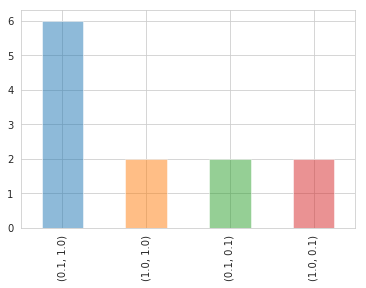

In [47]:
df_all['rs'] = list(zip(df_all['r'], df_all['s']))
df_all['rs'].value_counts().plot(kind='bar', alpha=0.5, stacked=False)

In [9]:
df_all['matthews_diff'] = df_all['matthews_svm'] -  df_all['matthews_log']
df_all['matthews_test_diff'] = df_all['test_matthews_svm'] - df_all['test_matthews_log']

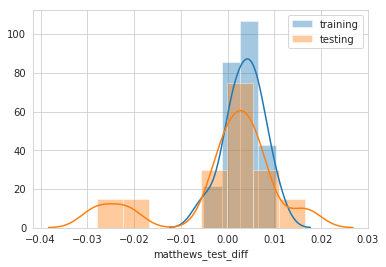

In [10]:
sns.distplot(df_all['matthews_diff'], label='training')
sns.distplot(df_all['matthews_test_diff'], label='testing')
plt.legend()

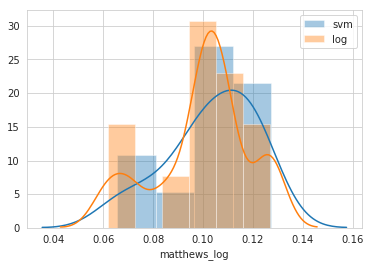

In [11]:
sns.distplot(df_all['matthews_svm'], label='svm')
sns.distplot(df_all['matthews_log'], label='log')
plt.legend()

In [12]:
df_all['matthews_diff'].sum(), df_all['matthews_test_diff'].sum()

(0.042978022636360733, -0.0099992725468177474)

In [18]:
df_all['matthews_diff'].median(), df_all['matthews_test_diff'].median()

(0.0038777078078651855, 0.001917985873108763)

In [19]:
df_all['matthews_diff'].mean(), df_all['matthews_test_diff'].mean()

(0.0035815018863633945, -0.0008332727122348123)

In [13]:
len(df_all[df_all['matthews_svm'] > df_all['matthews_log']][all_columns]), len(df_all[df_all['test_matthews_svm'] > df_all['test_matthews_log']]), len(df_all)

(11, 8, 12)

In [14]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

,features,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock,f1_svm,f1_log,test_f1_svm,test_f1_log
1,pca_gdf_que3,0.121660,0.126827,0.090541,0.118561,0.560428,0.562089,0.544144,0.559265,9063,0.485768,0.536674,0.488224,0.565703
6,pca_gdf_que3,0.101184,0.098597,0.105625,0.127183,0.550136,0.548357,0.552812,0.563175,9069,0.551510,0.574155,0.556987,0.589011
9,pca_gdf_que3,0.089446,0.085573,0.090150,0.091787,0.544344,0.542407,0.544234,0.544762,9064,0.523379,0.564138,0.498538,0.594997
11,pca_gdf_que3,0.065637,0.061754,0.078658,0.080730,0.532781,0.530758,0.539286,0.540134,9062,0.542193,0.548582,0.552350,0.566121


In [15]:
len(df_all[df_all['roc_auc_svm'] > df_all['roc_auc_log']][all_columns]), len(df_all[df_all['test_roc_auc_svm'] > df_all['test_roc_auc_log']][all_columns]), len(df_all)

(11, 8, 12)

In [16]:
df_all[df_all['test_matthews_svm'] < df_all['test_matthews_log']][all_columns]

,features,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock,f1_svm,f1_log,test_f1_svm,test_f1_log
1,pca_gdf_que3,0.121660,0.126827,0.090541,0.118561,0.560428,0.562089,0.544144,0.559265,9063,0.485768,0.536674,0.488224,0.565703
6,pca_gdf_que3,0.101184,0.098597,0.105625,0.127183,0.550136,0.548357,0.552812,0.563175,9069,0.551510,0.574155,0.556987,0.589011
9,pca_gdf_que3,0.089446,0.085573,0.090150,0.091787,0.544344,0.542407,0.544234,0.544762,9064,0.523379,0.564138,0.498538,0.594997
11,pca_gdf_que3,0.065637,0.061754,0.078658,0.080730,0.532781,0.530758,0.539286,0.540134,9062,0.542193,0.548582,0.552350,0.566121


In [17]:
df_all[df_all['test_roc_auc_svm'] < df_all['test_roc_auc_log']][all_columns]

,features,matthews_svm,matthews_log,test_matthews_svm,test_matthews_log,roc_auc_svm,roc_auc_log,test_roc_auc_svm,test_roc_auc_log,stock,f1_svm,f1_log,test_f1_svm,test_f1_log
1,pca_gdf_que3,0.121660,0.126827,0.090541,0.118561,0.560428,0.562089,0.544144,0.559265,9063,0.485768,0.536674,0.488224,0.565703
6,pca_gdf_que3,0.101184,0.098597,0.105625,0.127183,0.550136,0.548357,0.552812,0.563175,9069,0.551510,0.574155,0.556987,0.589011
9,pca_gdf_que3,0.089446,0.085573,0.090150,0.091787,0.544344,0.542407,0.544234,0.544762,9064,0.523379,0.564138,0.498538,0.594997
11,pca_gdf_que3,0.065637,0.061754,0.078658,0.080730,0.532781,0.530758,0.539286,0.540134,9062,0.542193,0.548582,0.552350,0.566121
